# Introduction
We will create a class of support vector machine (SVM, support vector machine) for classification by scratch. We will implement the algorithm using only the minimum library such as NumPy.


There are soft margin SVMs that allow classification errors during learning and hard margin SVMs that do not, but here we will deal with hard margin SVMs that are simple to implement.



In [51]:
#predefines and imports
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Prototype

In [52]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
class ScratchSVMClassifier():
    """
    Scratch implementation of SVM classifier
    Parameters
    ----------
    num_iter : int
      Number of iterations
    lr : float
      Learning rate
    kernel : str
      Kernel type. Linear kernel (linear) or polynomial kernel (polly)
    threshold : float
      Threshold for choosing a support vector
    verbose : bool
      True to output the learning process
    Attributes
    ----------
    self.n_support_vectors : int
      Number of support vectors
    self.index_support_vectors : The following form of ndarray, shape (n_support_vectors,)
      Support vector index
    self.X_sv :  The following forms of ndarray, shape (n_support_vectors, n_features)
      Support vector features
    self.lam_sv :  The following forms of ndarray, shape (n_support_vectors, 1)
      Support vector undetermined multiplier
    self.y_sv :  The following forms of ndarray, shape (n_support_vectors, 1)
      Support vector label
    """
    def __init__(self, num_iter, lr, kernel='linear', threshold=1e-5, degree = 2, verbose=False, debug = False, improved = False):
        # Record hyperparameters as attributes
        self.iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.threshold = threshold
        self.verbose = verbose
        self.debug = debug
        self.improved = improved
        self.degree = degree
    def kernel_function(self,Xi,Xj):
      if self.kernel == 'linear':
        result = Xi @ Xj.T
      if self.kernel == 'simple_poli':
        result = (Xi @ Xj.T + 1)**self.degree

      # print('Kernel shape: ',result.shape)
      return result
    def fit(self, X, y, X_val=None, y_val=None):

        #Prep part
        np.random.seed(2000)
        self.lagrange_multiplier = np.random.rand(X.shape[0],1) #this can be dim 1 or 0
        y = y.reshape(-1,1)
        y_val = y_val.reshape(-1,1) if y_val else None

        if self.verbose:
          print('Xshape: ', X.shape, 'yshape: ', y.shape)
          if X_val:
            print('XValshape: ', X_val.shape, 'yvalshape: ', y_val.shape)
        
        #Learn part
        if self.debug:
          print('Origin lagrange_multiplier: ')
          print(self.lagrange_multiplier)
        for i in range(self.iter):
          self.update_lagrange(X,y)
              
        
        #get sv part
        sv_index = []
        for idx, l in enumerate(self.lagrange_multiplier):
          if l > self.threshold: sv_index.append(idx)
        self.support_vectors_ = X[sv_index]
        self.n_support_vectors = len(sv_index)
        self.sv_lagrange = self.lagrange_multiplier[sv_index]
        self.sv_labels = y[sv_index]

        #validation part
        self.train_score = self.validate(X,y)
        self.valid_score = self.validate(X_val,y_val) if X_val else {'Score':'No validation set!'}


        # verbose part
        if self.verbose:
            result = pd.DataFrame({
              # 'SV Index': np.array(sv_index).reshape(-1,1),
              'support_vectors':[str(x) for x in self.support_vectors_],
              'label': self.sv_labels.ravel(),
              'L-multiple: ' : self.sv_lagrange.ravel()
            }, index = sv_index)
            print('Number of SVs: ', self.n_support_vectors)
            print(result)
            print('Training Score: ')
            print(pd.DataFrame(self.train_score, index = [0]))
            print('Validation Score: ')
            print(pd.DataFrame(self.valid_score, index = [0]))
            if self.debug: print('LagrangeMultiplier: ', self.lagrange_multiplier)
            
    def validate(self,X_val,y_val):
      pred = self.predict(X_val)
      acc = accuracy_score(pred,y_val)
      pre = precision_score(pred,y_val)
      rec = recall_score(pred,y_val)
      f1 = f1_score(pred,y_val)
      return {'Accuracy:': acc, 'Precision: ': pre, 'Recall: ':rec , 'F1-Score: ':f1}
      
    def update_lagrange(self,X,y):

      if self.improved:
        lm = self.lagrange_multiplier
        kernel_matrix = self.kernel_function(X,X) # precalculate, can put this outside the learning loop also!
        for i in range(lm.shape[0]):
          temp = y * lm * kernel_matrix[i].reshape(-1,1)
          gradient_i = 1 - y[i]* temp.sum()
          lm[i] = max(0, lm[i] + self.lr * gradient_i)
        return



      lm = self.lagrange_multiplier
      for i in range(lm.shape[0]): #! update each lagrange multiple
        temp = 0
        #calc sum
        for j in range(lm.shape[0]):
          # if i == j: continue
          temp += y[i]* lm[j] * y[j] * self.kernel_function(X[i], X[j])
          # print(self.kernel_function(X[i],X[j]))
        #update
        lm[i] = max(0,lm[i] + self.lr * (1 - temp))

    def predict(self, X):
      if self.improved:
        #improved prediction code
        fx = self.kernel_function(X,self.support_vectors_) @ (self.sv_lagrange * self.sv_labels)
        sign = np.vectorize(lambda x: -1 if x<0 else 1)
        return sign(fx)
        
      #prep
      result = np.zeros((X.shape[0],1))
      #predict 
      for i in range(X.shape[0]):
        result[i] = self.predict_x(X[i])
      return result
    def predict_x(self,x):
      fx = 0
      for i in range(self.n_support_vectors):
        fx += self.sv_lagrange[i] * self.sv_labels[i] * self.kernel_function(x, self.support_vectors_[i])
      sign = lambda x:  1 if x > 0 else -1
      return sign(fx)
    

In [53]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    # settings
    scatter_color = ['red', 'blue']
    contourf_color =  ['pink', 'skyblue']
    n_class = 2

    # prepare meshgrid
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]

    # predict
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)

    #plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)

    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    #!plot svs
    plt.scatter(model.support_vectors_[:,0], model.support_vectors_[:,1],color = 'yellow',s=80, label = 'SV')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

# My Test

Xshape:  (4, 2) yshape:  (4, 1)
Number of SVs:  3
  support_vectors  label  L-multiple: 
0           [1 1]     -1    143.205821
1           [2 1]     -1      2.428571
3           [2 2]      1     73.531482
Training Score: 
   Accuracy:  Precision:   Recall:   F1-Score: 
0       0.75          1.0  0.666667         0.8
Validation Score: 
                Score
0  No validation set!
Prediction:  [ 1 -1  1  1]
----------------------
[LibSVM]SV: 
[[1. 1.]
 [2. 1.]
 [1. 2.]
 [2. 2.]]
Lambda: 
[[1. 1. 1. 1.]]
My model: 


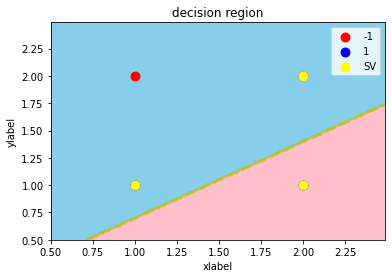

Sklearn: 


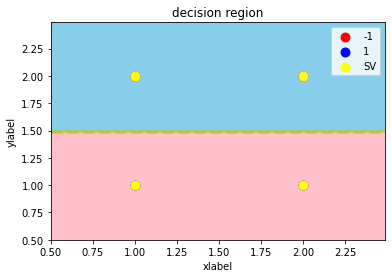

In [54]:
# ! simple test!

from sklearn.svm import SVC
ssvm = ScratchSVMClassifier(1000,0.1,verbose = True,debug = False, improved = True)
x = np.array([[1,1],
    [2,1],
    [1,2],
    [2,2]])
y = np.array([-1,-1,1,1])
ssvm.fit(x,y)
print('Prediction: ',ssvm.predict(x).ravel())


print('----------------------')
svc = SVC(kernel = 'linear', max_iter = 1000, verbose = True, tol = 1e-5)
svc.fit(x,y)
svc.predict(x)
print('SV: ')
print (svc.support_vectors_)
print('Lambda: ')
print(np.abs(svc.dual_coef_))

print('My model: ')
decision_region(x,y,ssvm,target_names = ['-1', '1'])
print('Sklearn: ')
decision_region(x,y,svc, target_names = ['-1', '1'])

# Problem 1,2,3,4
Gradient, SV determination, Estimation, Validation

In [55]:
# Simple dataset:
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]
f0 = np.random.multivariate_normal(f0, cov, n_samples // 2)
f1 = np.random.multivariate_normal(f1, cov, n_samples // 2)
X = np.concatenate([f0, f1])
y = np.concatenate([
    np.full(n_samples // 2, 1),
    np.full(n_samples // 2, -1)
])


# test

print('My result: ')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
x_train,x_test,y_train,y_test = train_test_split(X,y, test_size = 0.2)
model = ScratchSVMClassifier(10,0.01,verbose = True, improved= True)
model.fit(x_train,y_train)
pred = model.predict(x_test)
print(confusion_matrix(pred,y_test))


print('Sklearn Result:')
svc.fit(x_train,y_train)
pred = svc.predict(x_test)
print(confusion_matrix(pred, y_test))
print('SV: ')
print (svc.support_vectors_)
print('Lambda: ')
print(np.abs(svc.dual_coef_))

My result: 
Xshape:  (400, 2) yshape:  (400, 1)
Number of SVs:  5
               support_vectors  label  L-multiple: 
355  [-0.68857552 -2.3249237 ]     -1      0.037890
392  [-0.60267959  1.39367004]      1      0.307703
393  [ 1.54672501 -0.66849693]     -1      0.263517
398  [ 2.15200819 -0.82653692]     -1      0.227412
399  [-0.52579325  2.20448625]      1      0.100734
Training Score: 
   Accuracy:  Precision:   Recall:   F1-Score: 
0        1.0          1.0       1.0         1.0
Validation Score: 
                Score
0  No validation set!
[[52  0]
 [ 0 48]]
Sklearn Result:
[LibSVM][[52  0]
 [ 0 48]]
SV: 
[[ 0.95883548 -0.42178667]
 [-0.55980595  1.00527315]]
Lambda: 
[[0.46053539 0.46053539]]


# Problem 5
Visualize Hyperplane

My model: 


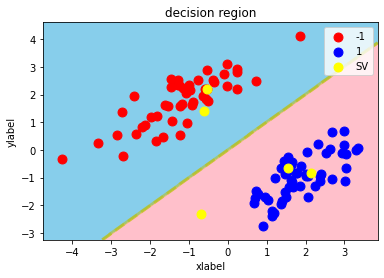

Sklearn: 


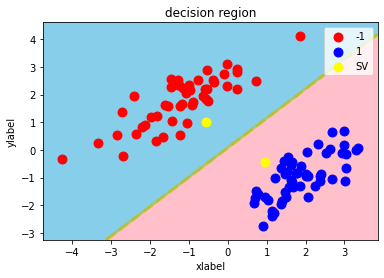

In [56]:
print('My model: ')
decision_region(x_test,y_test,model,target_names = ['-1', '1'])
print('Sklearn: ')
decision_region(x_test,y_test,svc, target_names = ['-1', '1'])

# Problem 6
Polinomial Kernel

Circle data set

Text(0, 0.5, '$x_2$')

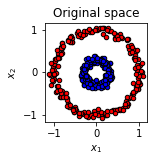

In [63]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=400, factor=.3, noise=.05)
plt.figure()
plt.subplot(2, 2, 1, aspect='equal')
plt.title("Original space")
reds = y == 0
blues = y == 1

plt.scatter(X[reds, 0], X[reds, 1], c="red",
            s=20, edgecolor='k')
plt.scatter(X[blues, 0], X[blues, 1], c="blue",
            s=20, edgecolor='k')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

In [64]:
y[y==0] = -1
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)
model = ScratchSVMClassifier(100,0.01,verbose = True, improved= True)
model.fit(x_train,y_train)
pred = model.predict(x_test)
print(confusion_matrix(pred,y_test))

Xshape:  (320, 2) yshape:  (320, 1)
Number of SVs:  320
               support_vectors  label  L-multiple: 
0    [-0.17637371 -0.2436637 ]      1      1.571342
1    [-0.91136163  0.1414564 ]     -1      1.508236
2    [-0.09137059 -0.98456163]     -1      1.523766
3      [0.08837427 0.2722006 ]      1      1.339341
4    [ 0.71398961 -0.72599803]     -1      1.443914
..                         ...    ...           ...
315  [ 0.47911421 -0.89435435]     -1      1.049559
316  [-0.32212462 -0.00190646]      1      1.380801
317    [0.12994549 1.03424205]     -1      1.951618
318  [-0.99935113 -0.15765518]     -1      1.330557
319    [1.06515701 0.21513172]     -1      1.314156

[320 rows x 3 columns]
Training Score: 
   Accuracy:  Precision:   Recall:   F1-Score: 
0        0.5     0.490066  0.471338    0.480519
Validation Score: 
                Score
0  No validation set!
[[15 22]
 [16 27]]


My model: 


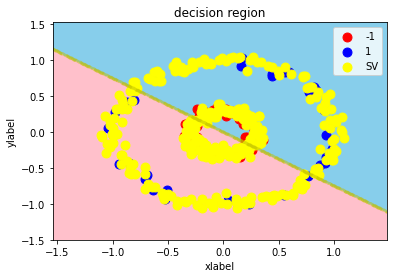

In [65]:
print('My model: ')
decision_region(x_test,y_test,model,target_names = ['-1', '1'])

Xshape:  (320, 2) yshape:  (320, 1)
Number of SVs:  101
               support_vectors  label  L-multiple: 
1    [-0.91136163  0.1414564 ]     -1      0.054892
6    [-0.8269962   0.43780305]     -1      0.009166
8    [-0.87126513  0.32727653]     -1      0.024192
18   [-0.18922931 -0.3331711 ]      1      0.067244
19   [-0.24031126 -0.08129393]      1      0.086042
..                         ...    ...           ...
295  [ 0.45615856 -0.8827025 ]     -1      0.063218
306    [0.27195554 0.05544494]      1      0.061095
307  [-0.0661633  -0.91083288]     -1      0.245913
311  [-0.22035567 -0.24364353]      1      0.000569
312  [ 0.3353564  -0.15578167]      1      0.017045

[101 rows x 3 columns]
Training Score: 
   Accuracy:  Precision:   Recall:   F1-Score: 
0        1.0          1.0       1.0         1.0
Validation Score: 
                Score
0  No validation set!
[[31  0]
 [ 0 49]]
New model: 


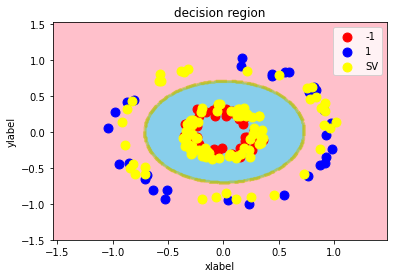

In [66]:
model = ScratchSVMClassifier(100,0.01,verbose = True, improved= True, kernel = 'simple_poli')
model.fit(x_train,y_train)
pred = model.predict(x_test)
print(confusion_matrix(pred,y_test))
print('New model: ')
decision_region(x_test,y_test,model,target_names = ['-1', '1'])

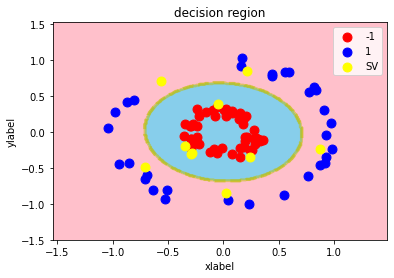

In [67]:
svc = SVC(kernel = 'poly', degree = 2)
svc.fit(x_train,y_train)
decision_region(x_test,y_test,svc,target_names = ['-1', '1'])

# Final Note & Questions:
- As you can see from the 'My Test' section, my model behave weird in such simple situation, I do not understand why it does this, any suggestion would be nice
- Eventhough, other classification tasks have been performed well by the model
- Improvements have been made to hasten the training and predition time
- Polinomial kernel has also been added!
- Though achieved same result as sklean's preditions, the scratch model does not have same support vectors, any idea why?